In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import random
from collections import deque

pd.options.display.max_columns = None

In [ ]:
# Action = Marketing Campaign Sent at a Given Time


In [2]:
# import pandas as pd
# import numpy as np
# import random
# from datetime import datetime, timedelta

# # -------------------------------
# # Parameters
# # -------------------------------
# num_customers = 100
# max_events_per_customer = 10

# # Define campaigns and their base conversion rates
# campaigns = {
#     "Email Promo": 0.15,
#     "SMS Offer": 0.20,
#     "Call": 0.25,
#     "No Action": 0.0
# }

# # Action to channel mapping
# action_to_channel = {
#     "Email Promo": "Email",
#     "SMS Offer": "SMS",
#     "Call": "Call",
#     "No Action": "None"
# }

# # Fatigue and reward penalty
# fatigue_penalty_per_repeat = 0.03
# reward_penalty_per_fatigue = 0.5

# # -------------------------------
# # Step 1: Generate Customer Profiles
# # -------------------------------
# locations = ['Mumbai', 'Delhi', 'Bangalore', 'Chennai']
# products = ['Credit Card', 'Loan', 'Savings Account', 'Insurance']

# profile_data = []
# for i in range(num_customers):
#     profile_data.append({
#         "customer_id": f"C{i:03d}",
#         "age": random.randint(22, 60),
#         "gender": random.choice(['M', 'F']),
#         "location": random.choice(locations),
#         "salary": random.randint(30000, 150000),
#         "product_owned": random.choice(products)
#     })

# df_profiles = pd.DataFrame(profile_data)
# df_profiles.to_csv("customer_profiles.csv", index=False)

# # -------------------------------
# # Step 2: Create Campaign Metadata
# # -------------------------------
# df_campaigns = pd.DataFrame([
#     {"action_name": k, "base_conversion_rate": v} for k, v in campaigns.items()
# ])
# df_campaigns.to_csv("campaign_metadata.csv", index=False)

# # -------------------------------
# # Step 3: Define Reward Function
# # -------------------------------
# def compute_reward(responded, converted, fatigue_count, action_taken):
#     if action_taken == "No Action":
#         return 0.0
#     if converted:
#         base = 20.0  # High reward for conversion
#     elif responded:
#         base = 2.0
#     else:
#         base = -1.0
#     penalty = fatigue_count * reward_penalty_per_fatigue
#     return max(base - penalty, -5.0)

# # -------------------------------
# # Step 4: Generate Customer Events
# # -------------------------------
# event_types = ['click', 'visit', 'purchase', 'login']
# all_events = []

# for customer in df_profiles['customer_id']:
#     fatigue_counter = {action: 0 for action in campaigns}
#     channel_fatigue = {"Email": 0, "SMS": 0, "Call": 0, "None": 0}
    
#     start_time = datetime(2023, 6, 1)
#     last_time = start_time

#     for step in range(max_events_per_customer):
#         action = random.choices(list(campaigns.keys()), weights=[0.4, 0.3, 0.2, 0.1])[0]
#         base_rate = campaigns[action]
#         fatigue = fatigue_counter[action]
#         adjusted_rate = max(base_rate - fatigue_penalty_per_repeat * fatigue, 0.01)

#         responded = 1 if random.random() < adjusted_rate + 0.1 else 0
#         converted = 1 if random.random() < adjusted_rate else 0

#         # Time handling
#         if step == 0:
#             gap_days = 0
#             event_time = start_time
#         else:
#             gap_days = random.randint(1, 5)
#             event_time = last_time + timedelta(days=gap_days)
#         last_time = event_time

#         # Other event data
#         event_type = random.choice(event_types)
#         amount = random.randint(100, 2000) if event_type == 'purchase' else 0

#         reward = compute_reward(responded, converted, fatigue, action)
#         channel = action_to_channel[action]

#         all_events.append({
#             "customer_id": customer,
#             "timestamp": event_time.strftime('%Y-%m-%d %H:%M:%S'),
#             "event_type": event_type,
#             "amount": amount,
#             "action_taken": action,
#             "channel": channel,
#             "responded": responded,
#             "converted": converted,
#             "fatigue_count": fatigue,
#             "gap_days": gap_days,
#             "reward": round(reward, 2)
#         })

#         # Update fatigue trackers
#         fatigue_counter[action] += 1
#         channel_fatigue[channel] += 1

#         if converted == 1:
#             break  # Stop on conversion

# # Save all events
# df_events = pd.DataFrame(all_events)
# df_events.to_csv("customer_events.csv", index=False)

# print("✅ Synthetic data generated with channel info and reward logic.")

In [3]:
import pandas as pd
import numpy as np
import random
from collections import deque
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Embedding, Concatenate,
    MultiHeadAttention, LayerNormalization,
    GlobalAveragePooling1D, Dropout, Lambda, Reshape
)


# from tensorflow.keras.layers import (
#     Input, Dense, Embedding, Concatenate,
#     MultiHeadAttention, LayerNormalization,
#     GlobalAveragePooling1D, Dropout, Lambda
# )


from tensorflow.keras.models import Model, clone_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# -------------------------------
# Load Data
# -------------------------------
events = pd.read_csv("customer_events.csv")
profiles = pd.read_csv("customer_profiles.csv")

# Merge to bring all features together
data = events.merge(profiles, on="customer_id", how="left")

In [4]:
import numpy as np
import pandas as pd
import random
from collections import deque
from tensorflow.keras.models import clone_model


In [5]:
# ---------------------------------------------------------------------------
# ✅ Environment Definition (Real Data Only)
# ---------------------------------------------------------------------------
class MarketingEnv:
    """
    Marketing Environment (Real Data Version)
    -----------------------------------------
    - Replays real customer interactions.
    - No simulation, fatigue, or base conversion probabilities.
    """

    def __init__(self, campaigns, max_seq_len=10):
        self.campaigns = campaigns
        self.max_seq_len = max_seq_len
        self.campaign_to_id = {c: i for i, c in enumerate(self.campaigns)}
        self.reset()

    def reset(self):
        """Start a new customer episode."""
        self.event_history = []
        self.response_history = []
        self.conversion_history = []
        self.gap_history = []
        self.state = {"responded": 0, "converted": 0, "gap_days": 0}
        self.steps = 0
        return self._get_state_vector()

    def _get_state_vector(self):
        """Return padded sequences for model input."""
        event_ids = [self.campaign_to_id.get(e, 0) for e in self.event_history[-self.max_seq_len:]]
        resp_flags = self.response_history[-self.max_seq_len:]
        conv_flags = self.conversion_history[-self.max_seq_len:]
        gap_values = self.gap_history[-self.max_seq_len:]

        pad_len = self.max_seq_len
        event_padded = np.zeros(pad_len, dtype=np.int32)
        resp_padded = np.zeros(pad_len, dtype=np.int32)
        conv_padded = np.zeros(pad_len, dtype=np.int32)
        gap_padded = np.zeros(pad_len, dtype=np.float32)

        event_padded[:len(event_ids)] = event_ids
        resp_padded[:len(resp_flags)] = resp_flags
        conv_padded[:len(conv_flags)] = conv_flags
        gap_padded[:len(gap_values)] = gap_values

        return (event_padded, resp_padded, conv_padded, gap_padded)

    def step(self, action_name, responded, converted, gap_days):
        """Replay one step from real dataset."""
        if responded is None or converted is None or gap_days is None:
            raise ValueError("All inputs (responded, converted, gap_days) must be provided.")

        # Update state
        self.state["responded"] = int(responded)
        self.state["converted"] = int(converted)
        self.state["gap_days"] = float(gap_days)

        # Reward logic (real data)
        if self.state["converted"]:
            reward = 20.0
        elif self.state["responded"]:
            reward = 2.0
        else:
            reward = -1.0

        # Update histories
        self.event_history.append(action_name)
        self.response_history.append(self.state["responded"])
        self.conversion_history.append(self.state["converted"])
        self.gap_history.append(self.state["gap_days"])
        self.steps += 1

        next_state = self._get_state_vector()
        done = self.state["converted"] or self.steps >= self.max_seq_len
        return next_state, reward, done


In [8]:
from tensorflow.keras.layers import Input, Embedding, Dense, Flatten, Concatenate, MultiHeadAttention, LayerNormalization, Add, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

def build_q_model(max_seq_len, num_event_types, profile_dim, num_actions,
                  embed_dim=32, ff_dim=64, num_heads=2):
    """
    Build Transformer-style Q-network for marketing RL.
    Inputs:
      - event, response, conversion, gap sequences
      - customer profile vector
    Outputs:
      - Q-values for each possible campaign action
    """

    # --- Sequence Inputs ---
    event_input = Input(shape=(max_seq_len,), name="event_seq")
    resp_input = Input(shape=(max_seq_len,), name="resp_seq")
    conv_input = Input(shape=(max_seq_len,), name="conv_seq")
    gap_input = Input(shape=(max_seq_len,), name="gap_seq")

    # --- Embeddings ---
    event_embed = Embedding(input_dim=num_event_types + 1, output_dim=embed_dim, mask_zero=True)(event_input)
    resp_embed = Embedding(input_dim=2, output_dim=embed_dim, mask_zero=True)(resp_input)
    conv_embed = Embedding(input_dim=2, output_dim=embed_dim, mask_zero=True)(conv_input)

    # --- Gap as numeric input ---
    gap_expanded = Reshape((max_seq_len, 1))(gap_input)
    gap_dense = Dense(embed_dim, activation="relu")(gap_expanded)

    # --- Combine all sequence embeddings ---
    seq_combined = Add()([event_embed, resp_embed, conv_embed, gap_dense])

    # --- Transformer Encoder Block ---
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(seq_combined, seq_combined)
    attn_output = Add()([seq_combined, attn_output])
    attn_output = LayerNormalization()(attn_output)

    ff = Dense(ff_dim, activation="relu")(attn_output)
    ff = Dense(embed_dim)(ff)
    ff_output = Add()([attn_output, ff])
    seq_encoded = LayerNormalization()(ff_output)

    # --- Flatten sequence representation ---
    seq_flat = Flatten()(seq_encoded)

    # --- Customer profile input ---
    profile_input = Input(shape=(profile_dim,), name="profile_vec")
    profile_dense = Dense(embed_dim, activation="relu")(profile_input)

    # --- Combine sequence + profile ---
    combined = Concatenate()([seq_flat, profile_dense])

    # --- Dense layers for Q-values ---
    x = Dense(128, activation="relu")(combined)
    x = Dense(64, activation="relu")(x)
    q_values = Dense(num_actions, activation="linear", name="q_values")(x)

    # --- Build & compile model ---
    model = Model(
        inputs=[event_input, resp_input, conv_input, gap_input, profile_input],
        outputs=q_values
    )

    model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse")
    return model


In [9]:
# ---------------------------------------------------------------------------
# ✅ Setup Variables from Dataset
# ---------------------------------------------------------------------------
# Example data references: events, profiles
# Make sure you’ve already loaded these as DataFrames

campaigns = events["action_taken"].unique().tolist()        # e.g. ['Email Promo', 'SMS Offer', 'Call', 'No Action']
max_seq_len = 10                                            # lookback length
num_event_types = len(campaigns)                            # number of campaign types
profile_dim = profiles.drop(columns=["customer_id"]).shape[1]  # number of profile features


In [10]:
# ---------------------------------------------------------------------------
# ✅ RL Training Configuration
# ---------------------------------------------------------------------------
num_episodes = 100
gamma = 0.95
epsilon = 1.0
epsilon_min = 0.1
epsilon_decay = 0.995
batch_size = 128
memory = deque(maxlen=2000)

env = MarketingEnv(campaigns=campaigns, max_seq_len=max_seq_len)
model = build_q_model(max_seq_len, num_event_types, profile_dim, len(campaigns))
target_model = clone_model(model)
target_model.set_weights(model.get_weights())


In [11]:
# ---------------------------------------------------------------------------
# ✅ Experience Replay
# ---------------------------------------------------------------------------
def replay():
    if len(memory) < batch_size:
        return 0.0

    minibatch = random.sample(memory, batch_size)
    states, targets = [], []

    for (state, action_idx, reward, next_state, done, profile_vec) in minibatch:
        event_seq, resp_seq, conv_seq, gap_seq = state
        next_event, next_resp, next_conv, next_gap = next_state

        q_values = model.predict(
            [event_seq[np.newaxis, :], resp_seq[np.newaxis, :],
             conv_seq[np.newaxis, :], gap_seq[np.newaxis, :],
             profile_vec[np.newaxis, :]], verbose=0
        )[0]

        if done:
            q_values[action_idx] = reward
        else:
            next_q = target_model.predict(
                [next_event[np.newaxis, :], next_resp[np.newaxis, :],
                 next_conv[np.newaxis, :], next_gap[np.newaxis, :],
                 profile_vec[np.newaxis, :]], verbose=0
            )[0]
            q_values[action_idx] = reward + gamma * np.max(next_q)

        states.append([event_seq, resp_seq, conv_seq, gap_seq, profile_vec])
        targets.append(q_values)

    # Convert to numpy arrays for training
    event_seq_batch = np.array([s[0] for s in states])
    resp_seq_batch = np.array([s[1] for s in states])
    conv_seq_batch = np.array([s[2] for s in states])
    gap_seq_batch = np.array([s[3] for s in states])
    profile_batch = np.array([s[4] for s in states])
    targets = np.array(targets)

    history = model.fit(
        [event_seq_batch, resp_seq_batch, conv_seq_batch, gap_seq_batch, profile_batch],
        targets, epochs=1, verbose=0
    )
    return float(history.history["loss"][0])


In [12]:
# ---------------------------------------------------------------------------
# ✅ Main RL Training Loop
# ---------------------------------------------------------------------------
# Track training metrics
episode_rewards = []
episode_losses = []
episode_epsilons = []


for episode in range(num_episodes):
    env.reset()
    total_reward = 0.0
    loss_value = 0.0
    chosen_actions = []

    # Pick one random customer per episode
    customer_id = random.choice(events["customer_id"].unique())
    cust_events = events[events["customer_id"] == customer_id].sort_values("timestamp").tail(max_seq_len)

    # Prepare profile vector
    cust_profile = profiles[profiles["customer_id"] == customer_id].drop(columns=["customer_id"]).copy()
    cust_profile["gender"] = cust_profile["gender"].map({"M": 0, "F": 1}).fillna(0)
    cust_profile["location"] = cust_profile["location"].astype("category").cat.codes
    cust_profile["product_owned"] = cust_profile["product_owned"].astype("category").cat.codes
    profile_vec = cust_profile.values.astype(np.float32)[0]

    # Iterate through events
    for idx, row in cust_events.iterrows():
        # Current state before action
        state = env._get_state_vector()

        # ε-greedy policy
        if np.random.rand() < epsilon:
            action_idx = np.random.choice(len(campaigns))
        else:
            q_values = model.predict(
                [state[0][np.newaxis, :], state[1][np.newaxis, :],
                 state[2][np.newaxis, :], state[3][np.newaxis, :],
                 profile_vec[np.newaxis, :]], verbose=0
            )[0]
            action_idx = np.argmax(q_values)

        action_name = campaigns[action_idx]
        chosen_actions.append(action_name)

        # Real data outcomes
        responded = row["responded"]
        converted = row["converted"]
        gap_days = row["gap_days"]

        # Environment step
        next_state, reward, done = env.step(action_name, responded, converted, gap_days)
        total_reward += reward

        # Store transition
        memory.append((state, action_idx, reward, next_state, done, profile_vec))

        # Learn from memory
        loss_value = replay()

        if done:
            break

    # Update target network & epsilon
    target_model.set_weights(model.get_weights())
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    # Log episode metrics
    episode_rewards.append(total_reward)
    episode_losses.append(loss_value)
    episode_epsilons.append(epsilon)
    
    print(f"Episode {episode+1}/{num_episodes} | Reward: {total_reward:.1f} | "
          f"Loss: {loss_value:.4f} | Epsilon: {epsilon:.3f} | Actions: {chosen_actions}")


Episode 1/100 | Reward: 20.0 | Loss: 0.0000 | Epsilon: 0.995 | Actions: ['No Action']
Episode 2/100 | Reward: 20.0 | Loss: 0.0000 | Epsilon: 0.990 | Actions: ['SMS Offer']
Episode 3/100 | Reward: 20.0 | Loss: 0.0000 | Epsilon: 0.985 | Actions: ['Call']
Episode 4/100 | Reward: 21.0 | Loss: 0.0000 | Epsilon: 0.980 | Actions: ['Call', 'No Action', 'SMS Offer']
Episode 5/100 | Reward: -4.0 | Loss: 0.0000 | Epsilon: 0.975 | Actions: ['SMS Offer', 'No Action', 'SMS Offer', 'SMS Offer', 'Call', 'Call', 'SMS Offer', 'Call', 'Call', 'SMS Offer']
Episode 6/100 | Reward: -1.0 | Loss: 0.0000 | Epsilon: 0.970 | Actions: ['Email Promo', 'No Action', 'No Action', 'Call', 'Email Promo', 'No Action', 'Email Promo', 'SMS Offer', 'Email Promo', 'No Action']
Episode 7/100 | Reward: 20.0 | Loss: 0.0000 | Epsilon: 0.966 | Actions: ['SMS Offer']
Episode 8/100 | Reward: 18.0 | Loss: 0.0000 | Epsilon: 0.961 | Actions: ['SMS Offer', 'SMS Offer', 'SMS Offer', 'Email Promo', 'No Action', 'Call']
Episode 9/100 | R

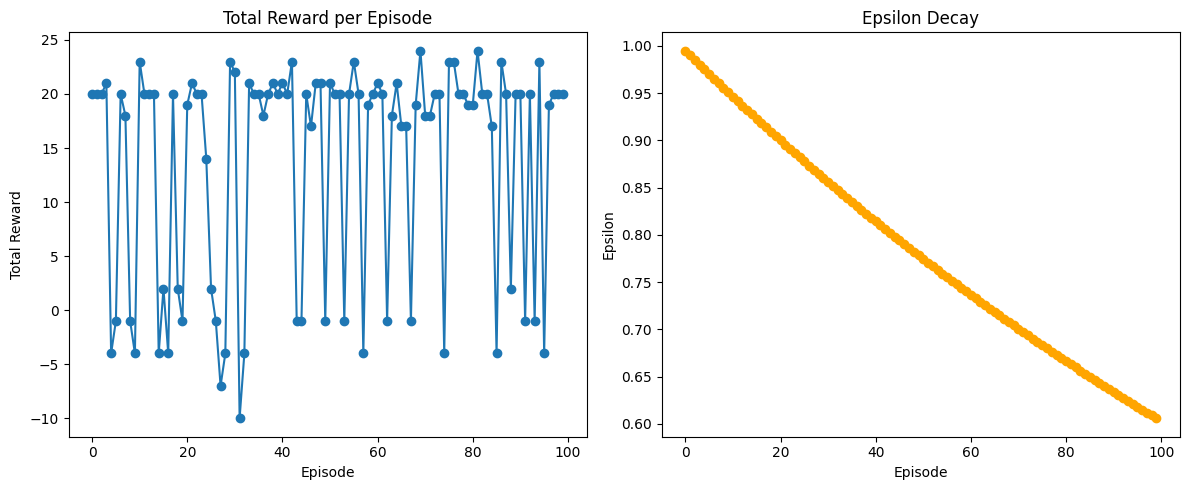

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(episode_rewards, marker='o')
plt.title("Total Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.plot(episode_epsilons, marker='o', color='orange')
plt.title("Epsilon Decay")
plt.xlabel("Episode")
plt.ylabel("Epsilon")

plt.tight_layout()
plt.show()


In [15]:
def recommend_next_campaign(customer_id):
    """
    Recommend the best next marketing campaign for a given customer.
    Uses the trained model and current state from real data.
    """
    cust_events = events[events["customer_id"] == customer_id].sort_values("timestamp").tail(max_seq_len)

    # Prepare sequences
    event_seq = np.zeros(max_seq_len, dtype=np.int32)
    resp_seq = np.zeros(max_seq_len, dtype=np.int32)
    conv_seq = np.zeros(max_seq_len, dtype=np.int32)
    gap_seq = np.zeros(max_seq_len, dtype=np.float32)

    for i, (_, row) in enumerate(cust_events.iterrows()):
        if i >= max_seq_len:
            break
        event_seq[i] = env.campaign_to_id.get(row["action_taken"], 0)
        resp_seq[i] = row["responded"]
        conv_seq[i] = row["converted"]
        gap_seq[i] = row["gap_days"]

    # Profile vector
    cust_profile = profiles[profiles["customer_id"] == customer_id].drop(columns=["customer_id"]).copy()
    cust_profile["gender"] = cust_profile["gender"].map({"M": 0, "F": 1}).fillna(0)
    cust_profile["location"] = cust_profile["location"].astype("category").cat.codes
    cust_profile["product_owned"] = cust_profile["product_owned"].astype("category").cat.codes
    profile_vec = cust_profile.values.astype(np.float32)[0]

    # Predict Q-values for all campaigns
    q_values = model.predict(
        [event_seq[np.newaxis, :], resp_seq[np.newaxis, :],
         conv_seq[np.newaxis, :], gap_seq[np.newaxis, :],
         profile_vec[np.newaxis, :]], verbose=0
    )[0]

    best_idx = np.argmax(q_values)
    best_campaign = campaigns[best_idx]

    print(f"✅ Recommended Next Campaign for {customer_id}: {best_campaign}")
    print(f"Q-values: {dict(zip(campaigns, np.round(q_values, 3)))}")

    return best_campaign


In [16]:
recommend_next_campaign("C000")
recommend_next_campaign("C004")


✅ Recommended Next Campaign for C000: No Action
Q-values: {'SMS Offer': np.float32(20.354), 'Email Promo': np.float32(22.737), 'Call': np.float32(21.779), 'No Action': np.float32(24.618)}
✅ Recommended Next Campaign for C004: Email Promo
Q-values: {'SMS Offer': np.float32(11.748), 'Email Promo': np.float32(20.699), 'Call': np.float32(16.816), 'No Action': np.float32(17.885)}


'Email Promo'